## Soical Network
### Build a Social Network and look at it through time.
Goals:
1. Build the network for each time-step
2. Use Community Detection Algos to cluster. Possibly use Core-periphery clustering instead (although this can probably just be done with centrality metrics)
3. Look at movement into core vs. periphery
4. Look at formation, splitting, merging of communities.

How:
1. Look at data [x]
2. See if it has user info [x]
3. See if it has info on which thread it was in. [x]
4. Chuck the data into time-steps (possibly over-lapping) [\_]
5. Create a directed link from writer towards all people who posted before them in a thread. [x]
6. Look at the network [x]
7. Cluster the network [x]
8. Look at the network thru time
9. Look at the clusters thru time

In [23]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk.sentiment.vader
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
import time
from sklearn.cluster import SpectralClustering
from sklearn import metrics
%matplotlib inline

In [3]:
dataset = pd.read_csv("csm subforums all posts cleaned.csv")

In [4]:
# dataset.head(10)

In [5]:
posts = dataset['Post']

#### Select posts during the incarna crisis
Do this for simplicity, we can expand it later.

In [6]:
# subset posts during the incarna crisis
dataset['Date_of_post'] =  pd.to_datetime(dataset['Date_of_post'],infer_datetime_format=True)


In [7]:
crisis_start = datetime.date(2011,3,1)
crisis_end = datetime.date(2011,9,1)
# (dataset['Date_of_post'].head() > crisis_start) & (dataset['Date_of_post'].head() < crisis_end)
mask = (crisis_start <= dataset['Date_of_post']) & (dataset['Date_of_post'] <= crisis_end)
posts_crisis = posts.loc[mask]
print('posts during crisis = ' + str( len(posts_crisis)))
posts_crisis.head()

posts during crisis = 32595


0    so we don't lose sight of all the summit topic...
1    what happened to the post of the long list of ...
2    csm5 was bad, fixing minor things/voting in th...
3    csm6 opted to forego player base consideration...
4    actually, you'll find that the topics we plan ...
Name: Post, dtype: object

### Let us start with non-directed affiliation networks first (they seem easier)
Create a link between people who posted in the same thread.
Plan ahead and put the other relevant info in the thread dict (date, post id)

In [63]:
df_sorted = dataset.sort_values(['all_thread_ids','Date_of_post'], ascending=[True, True])
df_sorted = df_sorted.reset_index()
# df_sorted

Analyzing the social network of all the posts was too computationally intensive and didn't complete. So I will chunk the posts into 1-week segments and see if it works.

Actually let's try 10k post segments and see if it works.

In [90]:
earliest = min(df_sorted['Date_of_post'])

In [129]:
start_time = time.time()


# This depends on the data frame to be sorted by thread first, then date


# create a dict of threads
thread_user = {}
# create a dict of user_to_thread
user_to_thread = {}
# create a dict of user_to_user
user_user_links = {} # (FROM,TO)
# place a link (or weight) from a user to all users above him in the thread(?)
last_thread_id = 0
last_date = datetime.datetime(1900,1,1) # set early date
same_day = False
users_in_thread_today = set() # set of users who posted today so ostensibly saw my post
users_before_me = set() # set of users who posted in the thread already

# for row_num in range(len(df_sorted)):
for row_num in range(1000):
    if row_num % 100 == 0:
        print(row_num)
    row = dataset.loc[row_num]
    this_user = row['Username']
    thread_ID = row['all_thread_ids']
    post_date = row['Date_of_post']
    
    
    if last_thread_id != thread_ID:
        users_in_thread_today = set() # set of users who posted today so ostensibly saw my post
        users_before_me = set() # set of users who posted in the thread already
    
    if last_date != post_date:
        users_in_thread_today = set()
    
    # put a link to all users ahead of me.
    for prior_commenter in users_before_me:
        if prior_commenter != this_user:
            if (this_user,prior_commenter) in user_user_links:
                user_user_links[(this_user,prior_commenter)][0] += 1
            else:
                user_user_links[(this_user,prior_commenter)] = [1,this_user,prior_commenter,thread_ID]
    
    # put a back link to me from all users in thread on same day. (ppl posting today may have seen this post)
    for prior_commenter in users_in_thread_today:
        if prior_commenter != this_user:
            if (prior_commenter,this_user) in user_user_links:
                user_user_links[(prior_commenter,this_user)][0] += 1
            else:
                user_user_links[(prior_commenter,this_user)] = [1,prior_commenter,this_user,thread_ID]
        
    # update this info to be the "last" for the next row
    prior_commenter = this_user
    last_date = post_date
    last_thread_id = thread_ID
    users_in_thread_today.add(this_user)
    users_before_me.add(this_user)
    
print("Done!")

end_time = time.time()
print(str(round(end_time - start_time,1)) + " seconds")

0
100
200
300
400
500
600
700
800
900
Done!
2.5 seconds


In [130]:
user_user_links_df = pd.DataFrame.from_dict(user_user_links, orient='index')#,columns=['weight', 'From', 'To'])
user_user_links_df.columns = ['weight', 'From', 'To','Thread']


In [131]:
user_user_links_df

,weight,From,To,Thread
"(Kethas Protagonist, Kel Archangel)",1,Kethas Protagonist,Kel Archangel,1555249
"(Planetary Genocide, Druthellion)",1,Planetary Genocide,Druthellion,1555249
"(ilammy's slave, Alexa Monk)",1,ilammy's slave,Alexa Monk,1555249
"(Kubiq, KayTwoEx)",1,Kubiq,KayTwoEx,1555249
"(d4shing, Varrent)",1,d4shing,Varrent,1555249
"(Aus Mote, Spinnakers)",1,Aus Mote,Spinnakers,1555249
"(Akiko Hanari, Super Chair)",1,Akiko Hanari,Super Chair,1555249
"(Alexa Monk, Almost29)",1,Alexa Monk,Almost29,1555249
"(Eerulee, Hirana Yoshida)",1,Eerulee,Hirana Yoshida,1555249
"(Arskaff, Casheddy)",1,Arskaff,Casheddy,1555249


In [132]:
n_nodes = len(user_user_links_df['From'].unique())
n_links = len(user_user_links_df)

In [133]:
n_links/(n_nodes*n_nodes)

0.5625366593215918

In [134]:
user_user_links_df

,weight,From,To,Thread
"(Kethas Protagonist, Kel Archangel)",1,Kethas Protagonist,Kel Archangel,1555249
"(Planetary Genocide, Druthellion)",1,Planetary Genocide,Druthellion,1555249
"(ilammy's slave, Alexa Monk)",1,ilammy's slave,Alexa Monk,1555249
"(Kubiq, KayTwoEx)",1,Kubiq,KayTwoEx,1555249
"(d4shing, Varrent)",1,d4shing,Varrent,1555249
"(Aus Mote, Spinnakers)",1,Aus Mote,Spinnakers,1555249
"(Akiko Hanari, Super Chair)",1,Akiko Hanari,Super Chair,1555249
"(Alexa Monk, Almost29)",1,Alexa Monk,Almost29,1555249
"(Eerulee, Hirana Yoshida)",1,Eerulee,Hirana Yoshida,1555249
"(Arskaff, Casheddy)",1,Arskaff,Casheddy,1555249


In [135]:
print(min(user_user_links_df['weight']))
# print(np.median(user_user_links_df['weight']))
print(np.mean(user_user_links_df['weight']))
print(max(user_user_links_df['weight']))


1
1.0237409629603063
33


In [136]:
start_time = time.time()
# print(start_time)

# Creating a Graph 
diG=nx.from_pandas_dataframe(user_user_links_df, 'From', 'To', ['weight'],create_using=nx.DiGraph())
unG=nx.from_pandas_dataframe(user_user_links_df, 'From', 'To', ['weight'])

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

# for 2k cells, 32 seconds
# for 10k cells, 29 seconds

Done!
5.3 seconds


(array([ 128.,   39.,    0.,    0.,    0.,    0.,    0.,  553.,  109.,    4.]),
 array([   0. ,   76.9,  153.8,  230.7,  307.6,  384.5,  461.4,  538.3,
         615.2,  692.1,  769. ]),
 <a list of 10 Patch objects>)

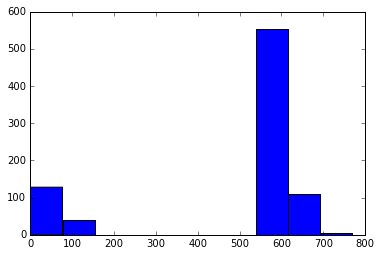

In [142]:
len(diG.nodes())
diG.degree()
plt.hist(list(diG.in_degree().values()))

It looks like the degrees (in degrees especially) are super skewed high - probably there were some threads that had ~ 600-800 users. If most of them posted on the same day then that is where most of the diadic links would come from. REALLY probably better to do Bi-partite affiliation networks. Then harder to measure "upstream" commenters as easily- what if someone just posts a lot in all the relevant things, but is a rando- they would appear to have very high centrality.

In [138]:
start_time = time.time()
print(start_time)

# compute eigenvalue centrality for the nodes
eig_cent = nx.eigenvector_centrality(diG)

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

# for 2k cells, 33 seconds

1544221411.562463
Done!
3.6 seconds


In [139]:
# start_time = time.time()
# print(start_time)

# nx.draw(diG,with_labels=False)
# end_time = time.time()
# print(end_time - start_time)

# # 45 sec for 1000 nodes

In [140]:
start_time = time.time()
partition = community.best_partition(unG)
community_id = [partition.get(node) for node in unG.nodes()]

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

# 7 sec for 1000 nodes

Done!
7.8 seconds


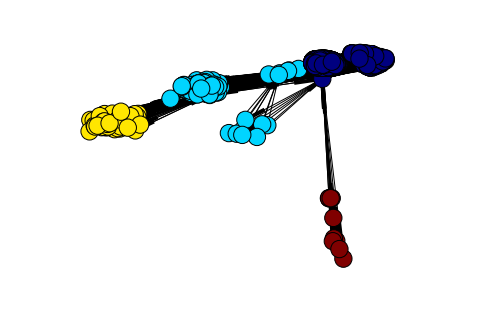

In [141]:
nx.draw(diG,with_labels=False,node_color=community_id)

In [124]:
# nx.draw(unG,with_labels=False,node_color=community_id)

In [125]:


start_time = time.time()

n_clusters = len(set(community_id))

# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(unG,weight='weights')

# Cluster
sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

# sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

Done!
0.5 seconds


//anaconda/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


1544221362.58909
Done!
0.6 seconds


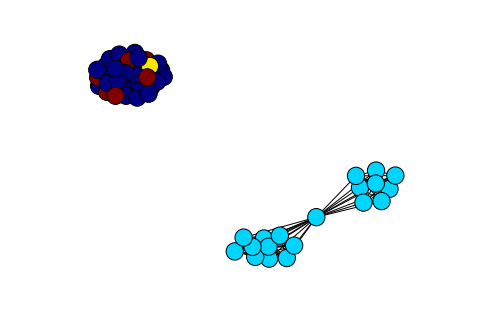

In [126]:
start_time = time.time()
print(start_time)

nx.draw(unG,with_labels=False,node_color=sc.labels_)
end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

Done!
0.2 seconds


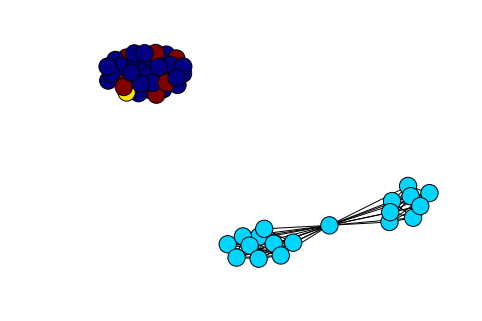

In [127]:
start_time = time.time()

nx.draw(unG,with_labels=False,node_color=sc.labels_)

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

Done!
0.5 seconds


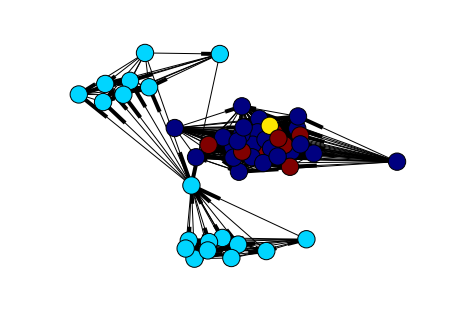

In [128]:
start_time = time.time()

nx.draw(diG,with_labels=False,node_color=sc.labels_)

end_time = time.time()
print("Done!")
print(str(round(end_time - start_time,1)) + " seconds")

ValueError: Color array must be two-dimensional

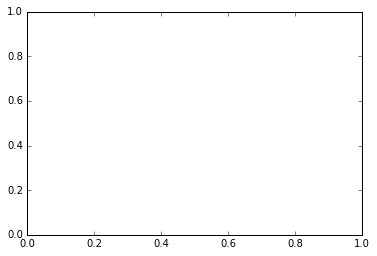

In [46]:
# nx.draw(unG,with_labels=False,node_color=list(parts.values()))

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(unG)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(unG, pos, list_nodes, node_size = 20,
                                node_color = np.array(list(partition.values())))


nx.draw_networkx_edges(unG, pos, alpha=0.5)
plt.show()

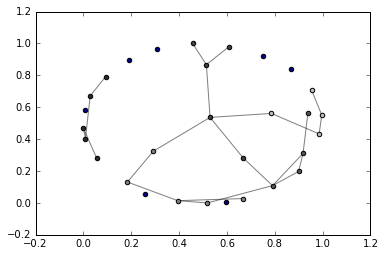

In [12]:
# Replace this with your networkx graph loading depending on your format !
G = nx.erdos_renyi_graph(30, 0.05)

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()